# Goal

Implement electricity demand forecasting with Gradient Boosting (XGBoost) ensemble tree method.

- Perform timeseries cross validation
- Leave 7-day window at end so there's always a test set

# Import Packages

Third-Pary packages:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import sys
from scipy.stats import skew
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

My core package:

In [2]:
# Auto reload core modules so I don't need to restart kernel when I change
# the code in those modules
%load_ext autoreload

In [3]:
sys.path.append('../')

from core.data import (
    add_temporal_features,
    TIME_FEATURES,
    cap_column_outliers,
    impute_null_demand_values,
)
from core.logging import get_logger

%aimport core.data
%aimport core.logging

In [4]:
lg = get_logger()
lg.info('test')
lg.handlers

test


[<StreamHandler stdout (INFO)>]

# Data

In [6]:
# Import Data
df = pd.read_csv('eia_api_pjm_demand.csv')

# Cast column types
df['utc_ts'] = pd.to_datetime(df['utc_ts'], utc=True)
df = df.set_index('utc_ts')
df['D'] = pd.to_numeric(df['D'])
df['DF'] = pd.to_numeric(df['DF'])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78840 entries, 2015-07-01 05:00:00+00:00 to 2024-06-28 04:00:00+00:00
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   respondent  78834 non-null  object 
 1   D           78667 non-null  float64
 2   DF          78551 non-null  float64
dtypes: float64(2), object(1)
memory usage: 2.4+ MB


# Outlier Detection and Capping

Plotting a histogram of the data shows all the data squished into a tiny bin. Clearly there must be an enourmous outlier.

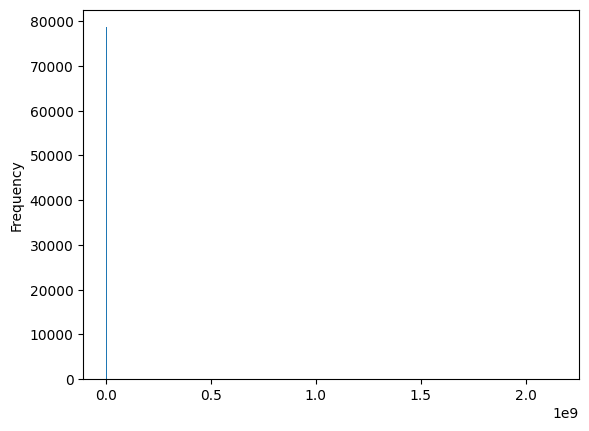

In [7]:
df.D.plot(kind='hist', bins=500)
plt.show()

In [8]:
print(f'median: {df.D.median()}')
print(f'mean: {df.D.mean()}')
print(f'skew: {skew(df.D.dropna())}')

median: 88308.0
mean: 143121.39789238182
skew: 199.54089885625248


Tweak and upper and lower threshold to find a reasonably small number of outliers.

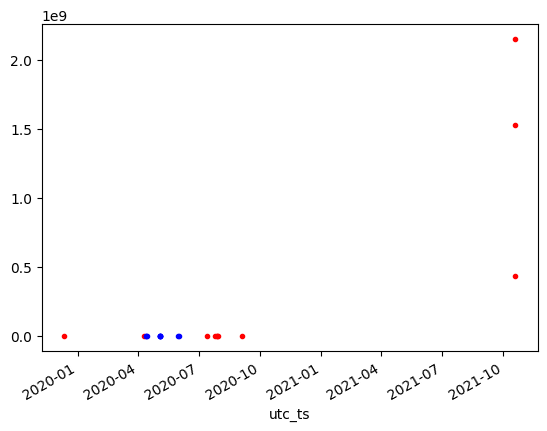

Number of upper outliers: 11
Number of lower outliers: 10


In [9]:
MAX_D_VAL = 165_000
MIN_D_VAL = 60_000
#upper_outliers = df.query(f'D > {MAX_D_VAL}')['D']
#lower_outliers = df.query(f'(D < {MIN_D_VAL})')['D']
upper_outliers = df[df.D > MAX_D_VAL].D
lower_outliers = df[df.D < MIN_D_VAL].D
upper_outliers.plot(style='.', color='r')
lower_outliers.plot(style='.', color='b')
plt.show()

print(f'Number of upper outliers: {len(upper_outliers)}')
print(f'Number of lower outliers: {len(lower_outliers)}')

<Axes: ylabel='Frequency'>

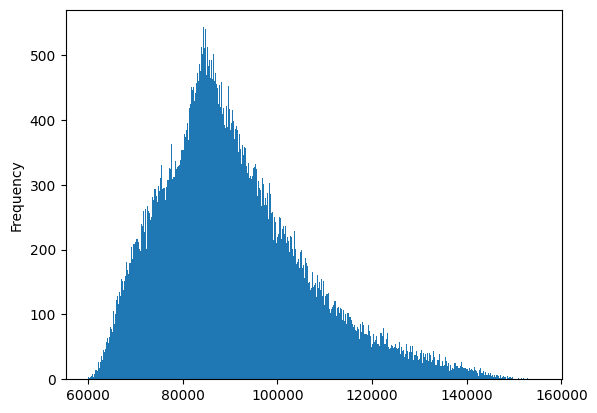

In [10]:
df[(df.D > MIN_D_VAL) & (df.D < MAX_D_VAL)].D.plot(kind='hist', bins=500)

Let's cap the outliers

In [11]:
df = cap_column_outliers(df, 'D', MIN_D_VAL, MAX_D_VAL)

Input data skew: 199.54089885625248
Output data skew: 0.8230879258634071


## Null value imputation

In [12]:
print(f'Number of null demand values: {sum(df.D.isnull())}')

Number of null demand values: 173


__Q__: Where do the null values occur?

__A__: Below we see that, across multiple years, most null values occur either early in the year (somewhere around day 40) or late in the year (somewhere around day 310).

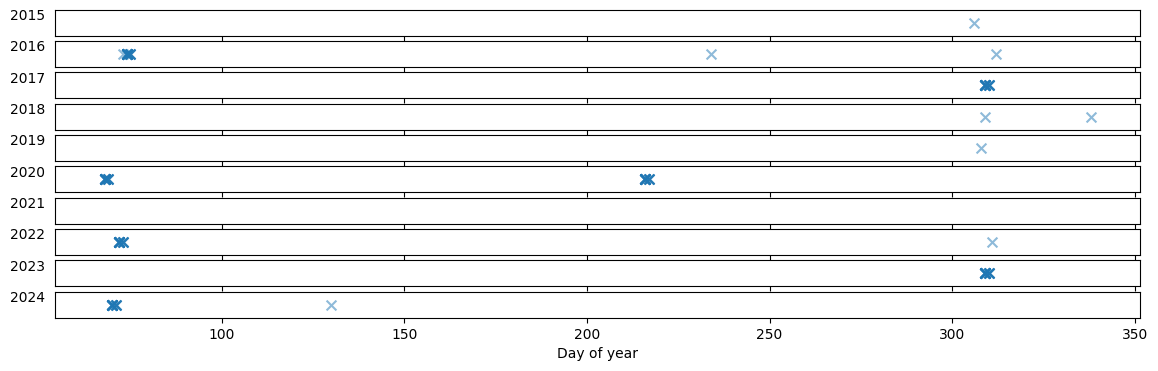

In [13]:
start_year = df.index.min().year
end_year = df.index.max().year
num_years = end_year - start_year + 1
fig, ax = plt.subplots(num_years, 1, figsize=(14, 4), sharex=True)
for i in range(num_years):
    year = start_year + i
    year_df = df[df.index.year == year]
    null_D = year_df.D.isnull().astype(int)
    null_D[null_D == 0] = np.nan
    ax[i].scatter(year_df.index.dayofyear, null_D, s=50.0, alpha=0.5, marker='x')
    ax[i].set_ylabel(year, rotation='horizontal', labelpad=20)
    ax[i].set_yticks([])
    ax[i].set_xlabel('Day of year')
plt.show()

Let's impute the null values as the average demand value for the given month and hour:

In [14]:
from collections import defaultdict
avg_D_by_month_hour = defaultdict(dict)
for month in np.arange(1, 12+1):
    for hour in np.arange(24):
        month_mask = df.index.month == month
        hour_mask = df.index.hour == hour
        avg_D_by_month_hour[month][hour] = df[month_mask & hour_mask].D.mean()

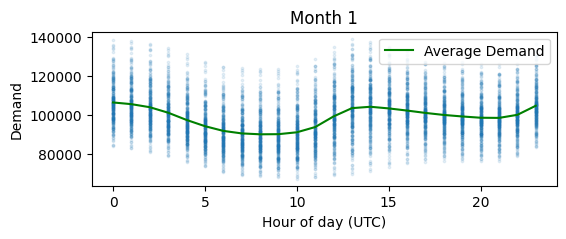

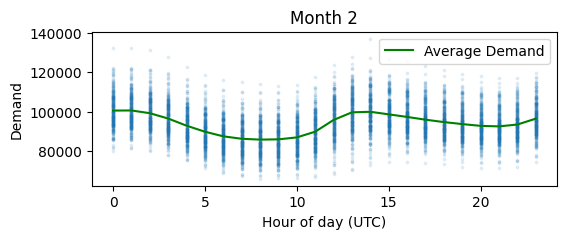

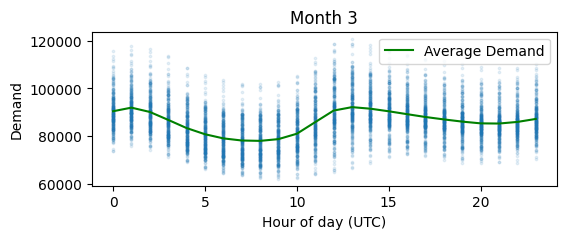

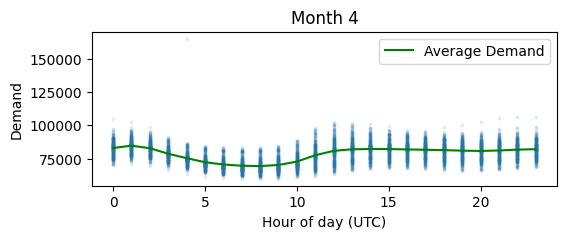

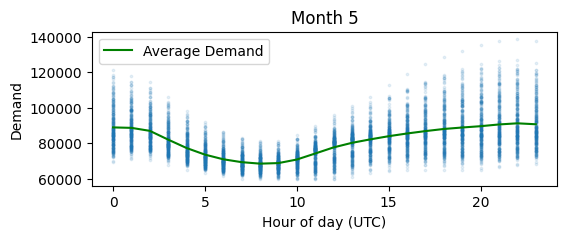

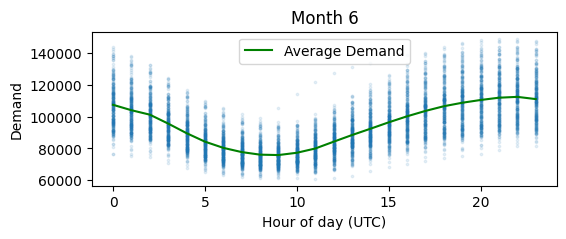

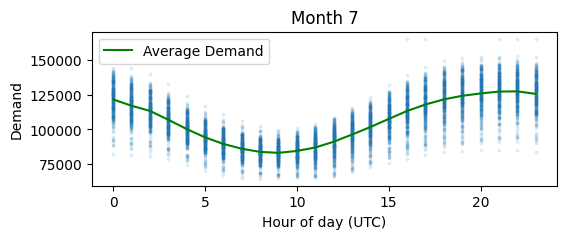

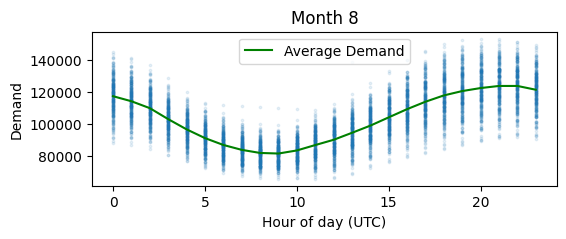

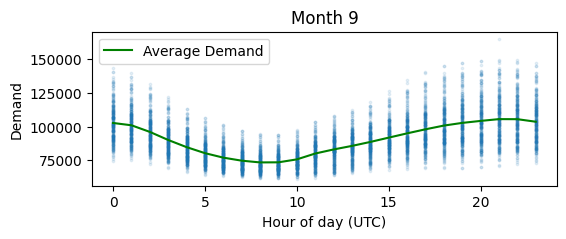

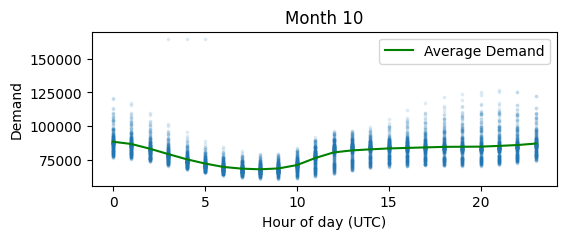

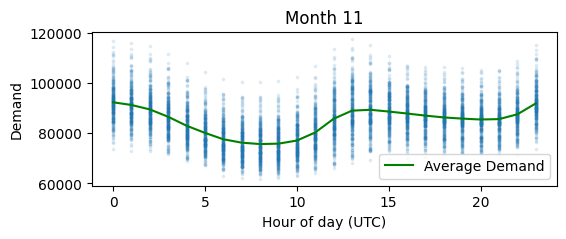

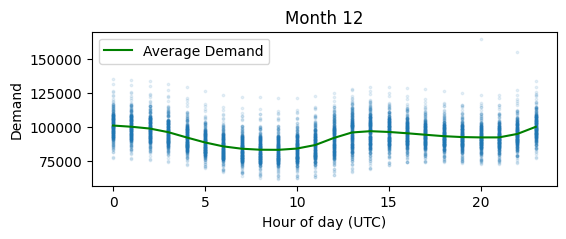

In [15]:
for month in np.arange(1, 12+1):
    avg_by_hour = avg_D_by_month_hour[month]
    temps = list(map(lambda h: avg_by_hour[h], np.arange(24)))
    month_df = df[df.index.month == month]
    fig, ax = plt.subplots(figsize=(6,2))
    plt.scatter(month_df.index.hour, month_df.D, s=3.0, alpha=0.1)
    plt.plot(np.arange(24), temps, color='g', label='Average Demand')
    plt.title(f'Month {month}')
    plt.xlabel('Hour of day (UTC)')
    plt.ylabel('Demand')
    plt.legend()
    plt.show()

In [16]:
df = impute_null_demand_values(df)

assert sum(df.D.isnull()) == 0

Null demand values: 173


# Timeseries Cross Validation

For timeseries, our K-fold cross validation splits must still preserve the sequential nature of our dataset (test set must always be later in time than training).

## Create and Visualize the train/test splits

In [17]:
# 2 weeks in hours
TEST_SET_SIZE = 14 * 24
NUM_SPLITS = 8

In [18]:
tss = TimeSeriesSplit(n_splits=NUM_SPLITS, test_size=TEST_SET_SIZE)
print(tss)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=336)


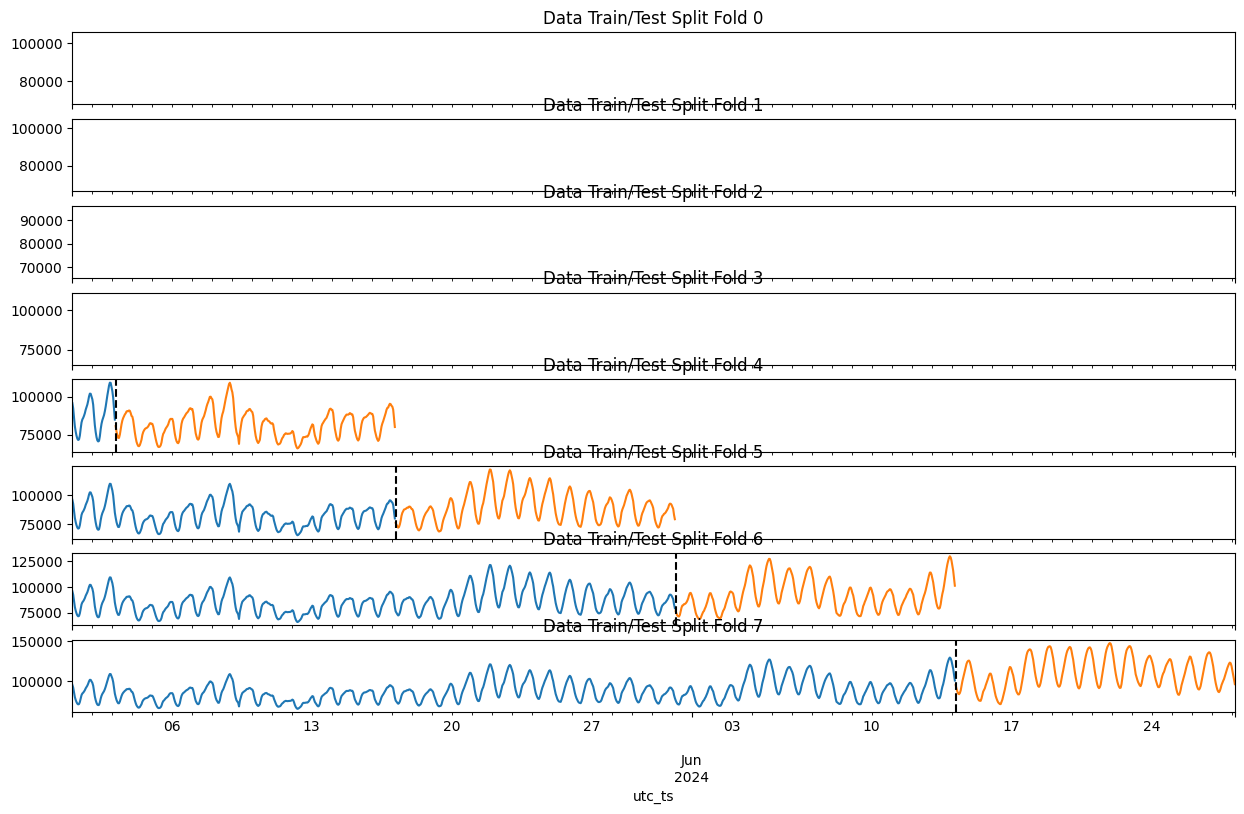

In [19]:
fig, axs = plt.subplots(NUM_SPLITS, 1, figsize=(15, 10), sharex=True)

for fold, (train_idx, val_idx) in enumerate(tss.split(df)):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    # Cut out bulk of common training data for better visualization
    train = train[train.index > '05-01-2024']
    train['D'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['D'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
plt.show()

# Feature Engineering

In [20]:
df = add_temporal_features(df)

In [21]:
df.head()

,respondent,D,DF,hour,month,year,quarter,dayofweek,dayofmonth,dayofyear
utc_ts,,,,,,,,,,
2015-07-01 05:00:00+00:00,PJM,84024.0,29415.0,5,7,2015,3,2,1,182
2015-07-01 06:00:00+00:00,PJM,79791.0,27687.0,6,7,2015,3,2,1,182
2015-07-01 07:00:00+00:00,PJM,76760.0,26574.0,7,7,2015,3,2,1,182
2015-07-01 08:00:00+00:00,PJM,74931.0,26029.0,8,7,2015,3,2,1,182
2015-07-01 09:00:00+00:00,PJM,74368.0,26220.0,9,7,2015,3,2,1,182


# Train the Model

In [22]:
FEATURES = TIME_FEATURES
TARGET = 'D'

y_preds = []
scores = []
for i, (train_idx, test_idx) in enumerate(tss.split(df)):
    print(f'FOLD {i}:')
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    print(f'Train set hours: {len(train)}.\nTest set hours: {len(test)}.')

    X_train, y_train = train[FEATURES], train[TARGET]
    X_test, y_test = test[FEATURES], test[TARGET]

    reg = xgb.XGBRegressor(booster='gbtree', n_estimators=1000, early_stopping_rounds=50, 
                           objective='reg:squarederror', max_depth=6, learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, y_pred))

    # Record this fold
    y_preds.append(y_pred)
    scores.append(score)
    print()

FOLD 0:
Train set hours: 76152.
Test set hours: 336.
[0]	validation_0-rmse:15577.59287	validation_1-rmse:27269.61158
[100]	validation_0-rmse:9859.29696	validation_1-rmse:20866.86052
[200]	validation_0-rmse:8276.46001	validation_1-rmse:19242.28676
[229]	validation_0-rmse:8023.44925	validation_1-rmse:19377.86419

FOLD 1:
Train set hours: 76488.
Test set hours: 336.
[0]	validation_0-rmse:15556.35704	validation_1-rmse:27292.82485
[100]	validation_0-rmse:9845.63839	validation_1-rmse:20835.05238
[200]	validation_0-rmse:8267.96019	validation_1-rmse:19290.98671
[223]	validation_0-rmse:8065.84867	validation_1-rmse:19397.65938

FOLD 2:
Train set hours: 76824.
Test set hours: 336.
[0]	validation_0-rmse:15534.43750	validation_1-rmse:27308.50377
[100]	validation_0-rmse:9834.75955	validation_1-rmse:20912.86139
[200]	validation_0-rmse:8262.91405	validation_1-rmse:19064.20570
[251]	validation_0-rmse:7860.76132	validation_1-rmse:19198.63766

FOLD 3:
Train set hours: 77160.
Test set hours: 336.
[0]	vali

In [23]:
print(f'Mean score: {np.mean(scores)}')

Mean score: 19345.503155239872


# Hyperparameter Tuning

In [24]:
parameters = {
    'n_estimators': [100, 1000], 
    'max_depth': [3, 5, 10], 
    'learning_rate': [0.01, 0.02, 0.04],
    'objective': ['reg:squarederror'],
}

reg = GridSearchCV(xgb.XGBRegressor(), parameters, cv = tss, verbose=2)
reg.fit(df[FEATURES], df[TARGET])

Fitting 8 folds for each of 18 candidates, totalling 144 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, objective=reg:squarederror; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, objective=reg:squarederror; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, objective=reg:squarederror; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, objective=reg:squarederror; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, objective=reg:squarederror; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, objective=reg:squarederror; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, objective=reg:squarederror; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, objective=reg:squarederror; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=1000, objective=reg:squared

KeyboardInterrupt: 

In [ ]:
cv_results_df = pd.DataFrame(reg.cv_results_).sort_values(by='rank_test_score')
#cv_results_df.head()
cv_results_df.head()

In [ ]:
# The default scoring method for XGBRegressor is R^2
reg.best_estimator_.score.__doc__

In [ ]:
reg.best_params_

Let's visualize the time/accuracy tradeoff of the different parameter sets (points in parameter space) we evaluated:

In [ ]:
x = cv_results_df['mean_fit_time']
y = cv_results_df['mean_test_score']
plt.scatter(x, y, alpha=0.5, s=100)
for (x_i, y_i, rank_i) in zip(x, y, cv_results_df['rank_test_score']):
    plt.text(x_i, y_i, rank_i, va='center', ha='center', size=8)
plt.xlabel('Mean fit time')
plt.ylabel('Mean R^2 Score')
plt.title('Parameter Set Ranks')
plt.plot()

## Visualize Feature Importances

In [ ]:
be = reg.best_estimator_
fi = pd.DataFrame(data=be.feature_importances_,
             index=be.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Visualizing Predictions

Let's visually compare the electricty demand predictions for the last week of data we have (which was never used for training).

In [ ]:
last_hour = df.iloc[-1].name
last_week_start = last_hour - pd.Timedelta(days=7)
last_week_df = df[df.index >= last_week_start]
X = last_week_df[FEATURES]
y = last_week_df[TARGET]
y_pred = reg.predict(X)

In [ ]:
plt.plot(last_week_df.index, y, label='target')
plt.plot(last_week_df.index, y_pred, label='prediction')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Demand')
plt.legend()
plt.show()

In [ ]:
from IPython import get_ipython
get_ipython().config

# References
- https://www.kaggle.com/code/robikscube/pt2-time-series-forecasting-with-xgboost/notebook